# Iris Feature Importance

In [38]:
from qiskit_algorithms.utils import algorithm_globals

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import clear_output
# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Machine learning and preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import shap
from alibi.explainers import ALE, plot_ale

In [39]:
shap.initjs()

Text(0.5, 1.02, 'Pairplot of Iris Dataset')

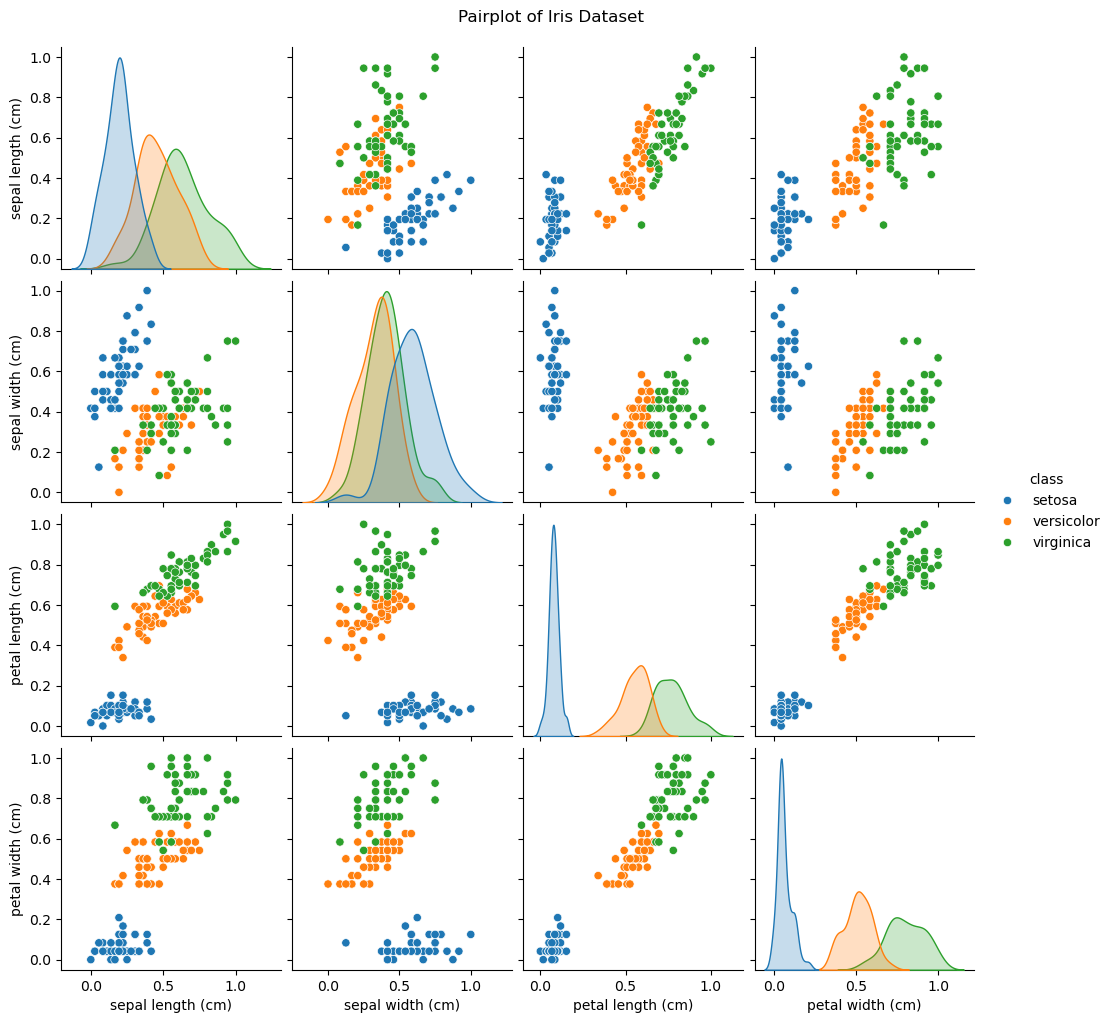

In [40]:
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
features = MinMaxScaler().fit_transform(features)
df = pd.DataFrame(features, columns=iris_data.feature_names)
df['class'] = [iris_data.target_names[label] for label in iris_data.target]


plot = sns.pairplot(df, hue='class', palette='tab10')
plot.fig.suptitle("Pairplot of Iris Dataset", y=1.02)

## LOO

In [41]:
iris_data = load_iris()
full_features = iris_data.data
labels = iris_data.target  

data_descriptions = ["Full Features", "Missing Sepal Length", "Missing Sepal Width", "Missing Petal Length",
                     "Missing Petal Width"]

In [42]:
progress = {}
iris_LOO_scores = {}

for i, description in enumerate(data_descriptions):
    if i == 0:
        adjusted_features = full_features.copy()
    else:
        adjusted_features = np.delete(full_features, i-1, axis=1)

    num_features = adjusted_features.shape[1]

    adjusted_features = MinMaxScaler().fit_transform(adjusted_features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        adjusted_features, labels, train_size=0.8, random_state=4701)

    iterations = range(1, 101)  
    train_scores = []
    test_scores = []

    warnings.filterwarnings('ignore')

    for i in iterations:
        svc = SVC()
        svc.fit(train_features, train_labels)  # fit the model

        test_score_classical = svc.score(test_features, test_labels)

        test_scores.append(test_score_classical)

    progress[description] = test_scores

    iris_LOO_scores[description] = {
        "Test": test_score_classical
    }


In [43]:
def LOO_scores_separate_plots(scores):
    full_feature_score = scores['Full Features']['Test']
    for feature_set, score_info in scores.items():
        if feature_set != 'Full Features':
            absolute_difference = abs(score_info['Test'] - full_feature_score)
            percentage_difference = (absolute_difference / full_feature_score) * 100
            scores[feature_set]['Absolute Difference'] = absolute_difference
            scores[feature_set]['Percentage Difference'] = percentage_difference

    categories = list(scores.keys())
    test_scores = [score_info['Test'] for score_info in scores.values()]
    abs_diff_scores = [score_info.get('Absolute Difference', 0) for score_info in scores.values()]
    perc_diff_scores = [score_info.get('Percentage Difference', 0) for score_info in scores.values()]

    # Test Scores 
    plt.figure(figsize=(10, 6))
    plt.barh(categories, test_scores, color='green')
    plt.axvline(x=full_feature_score, color='red', linestyle='--', label='Full Features Score')
    plt.xlabel('Test Scores')
    plt.title('Classical SVC Test Dataset Scores')
    plt.legend()
    plt.tight_layout()
    plt.savefig('Visuals/iris_LOO_classical_SVC_test_scores.png')
    plt.show()

    # Absolute Difference 
    plt.figure(figsize=(10, 6))
    plt.barh(categories, abs_diff_scores, color='salmon')
    plt.xlabel('Absolute Difference')
    plt.title('Absolute Difference from Full Features (Classical SVC)')
    plt.tight_layout()
    plt.savefig('Visuals/iris_LOO_classical_SVC_absolute_difference.png')
    plt.show()

    # Percentage Difference 
    plt.figure(figsize=(10, 6))
    plt.barh(categories, perc_diff_scores, color='orange')
    plt.xlabel('Percentage Difference (%)')
    plt.title('Percentage Difference from Full Features (Classical SVC)')
    plt.tight_layout()
    plt.savefig('Visuals/iris_LOO_classical_SVC_percentage_difference.png')
    plt.show()
    plt.close()


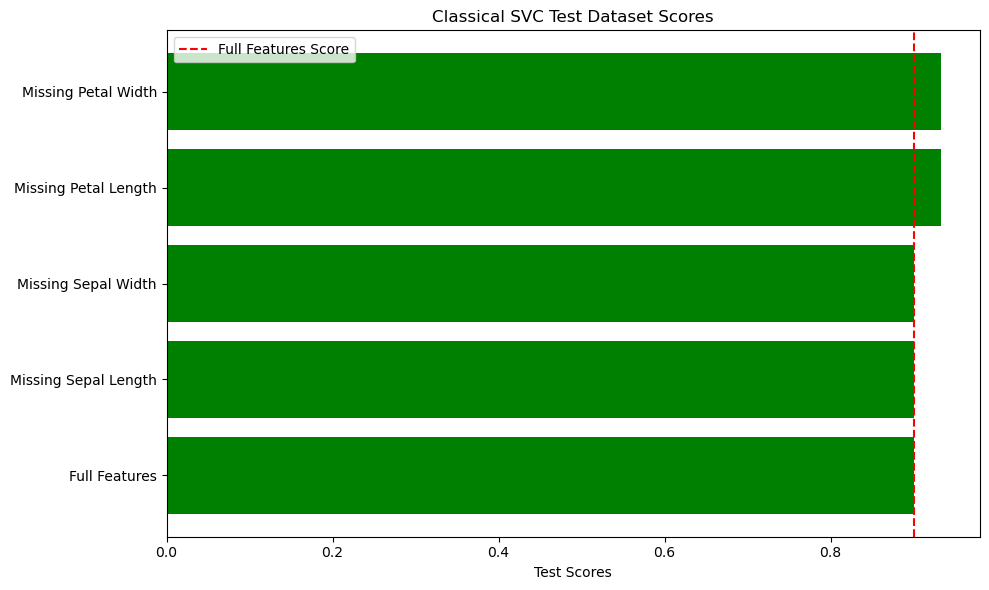

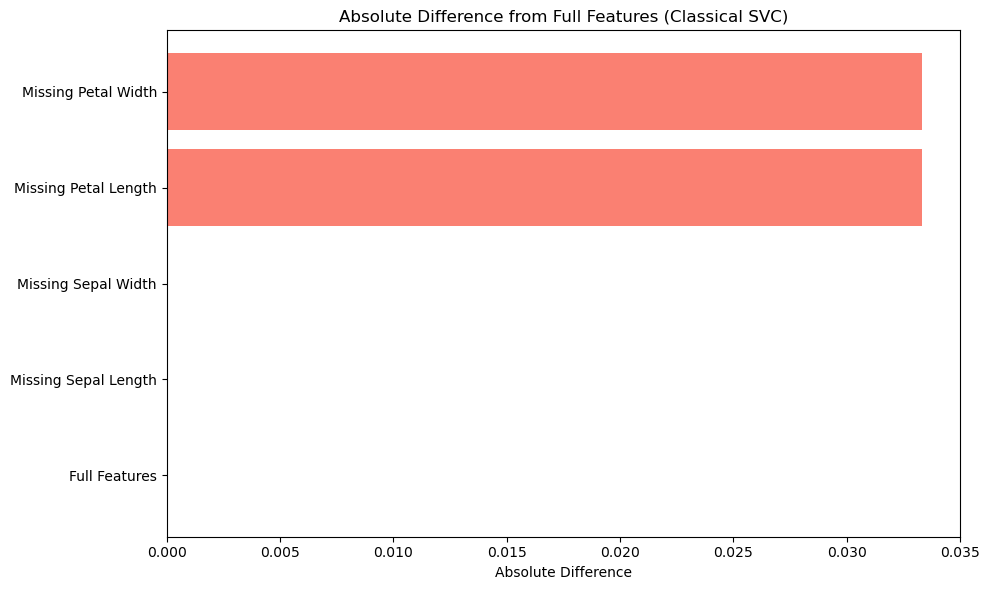

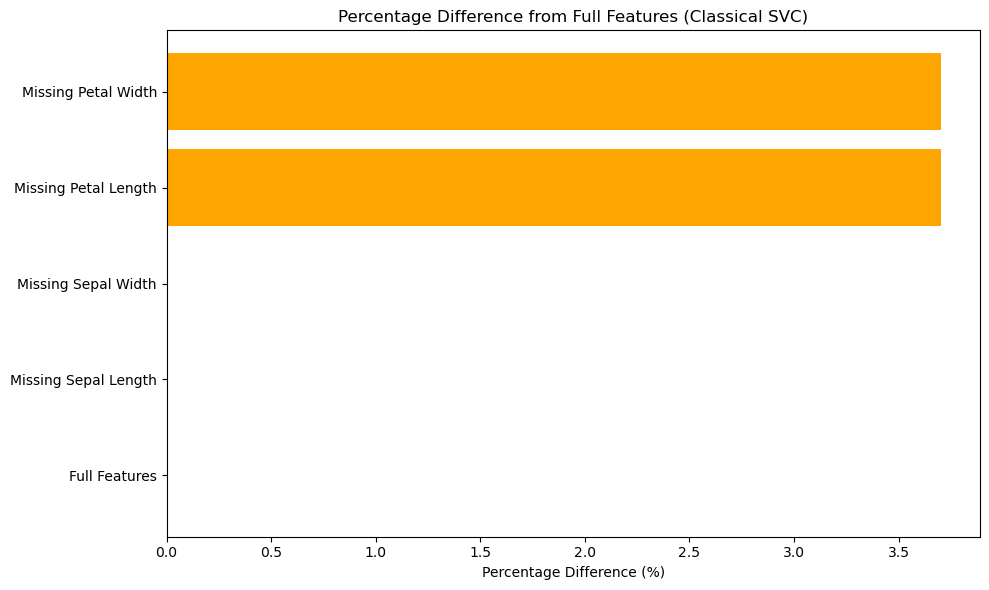

In [44]:
LOO_scores_separate_plots(iris_LOO_scores)

## ALE

In [45]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names


train_features, test_features, train_labels, test_labels = train_test_split(
        X, y, train_size=0.8, random_state=4701)

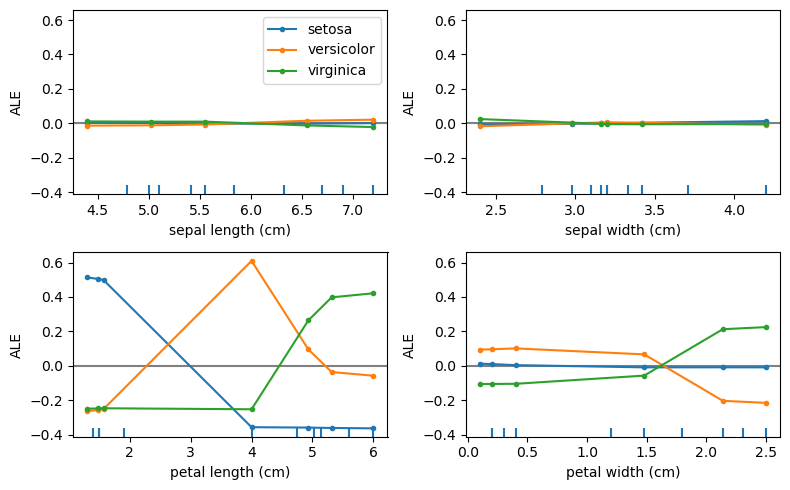

In [53]:
svc_model = SVC(probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=4701)

svc_model.fit(train_features, train_labels)
rf_model.fit(train_features, train_labels)

# Define prediction functions
def predict_fn_svc(x):
    return svc_model.predict_proba(x)

def predict_fn_rf(x):
    return rf_model.predict_proba(x)

ale_svc = ALE(predict_fn_svc, feature_names=feature_names, target_names=target_names)
ale_rf = ALE(predict_fn_rf, feature_names=feature_names, target_names=target_names)


exp_svc = ale_svc.explain(test_features)
exp_rf = ale_rf.explain(test_features)

#  SVC model
plot_ale(exp_svc, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});

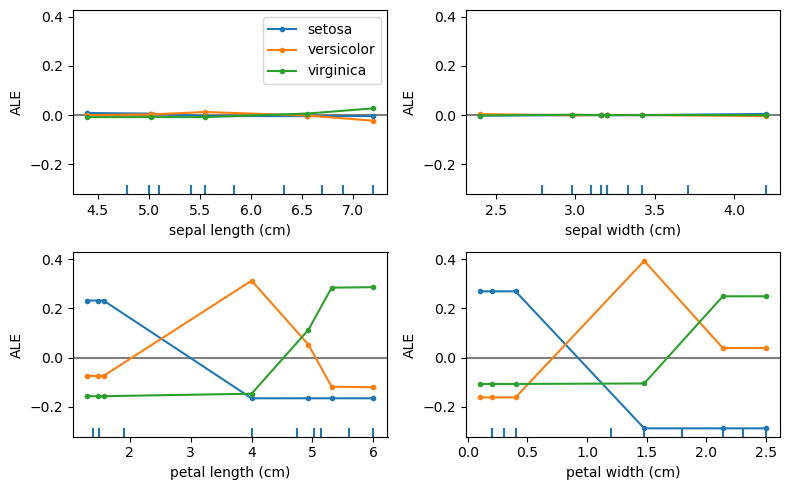

In [54]:
plot_ale(exp_rf, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});

In [48]:
from qiskit_machine_learning.algorithms import QSVC
qsvc_model = QSVC.load('quantum_classifiers/iris_qsvc.model')

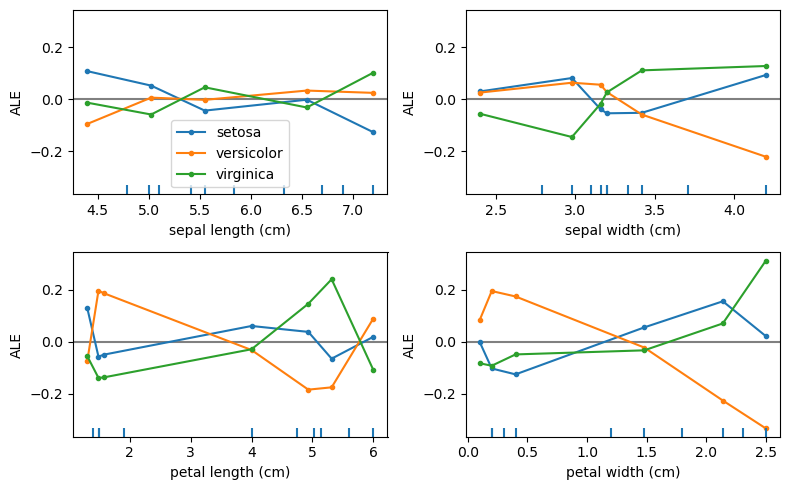

In [49]:

def predict_fn_qsvc(x):
    return qsvc_model.predict_proba(x)

ale_qsvc = ALE(predict_fn_qsvc, feature_names=feature_names, target_names=target_names)

exp_qsvc = ale_qsvc.explain(test_features)

#  SVC model
plot_ale(exp_qsvc, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});

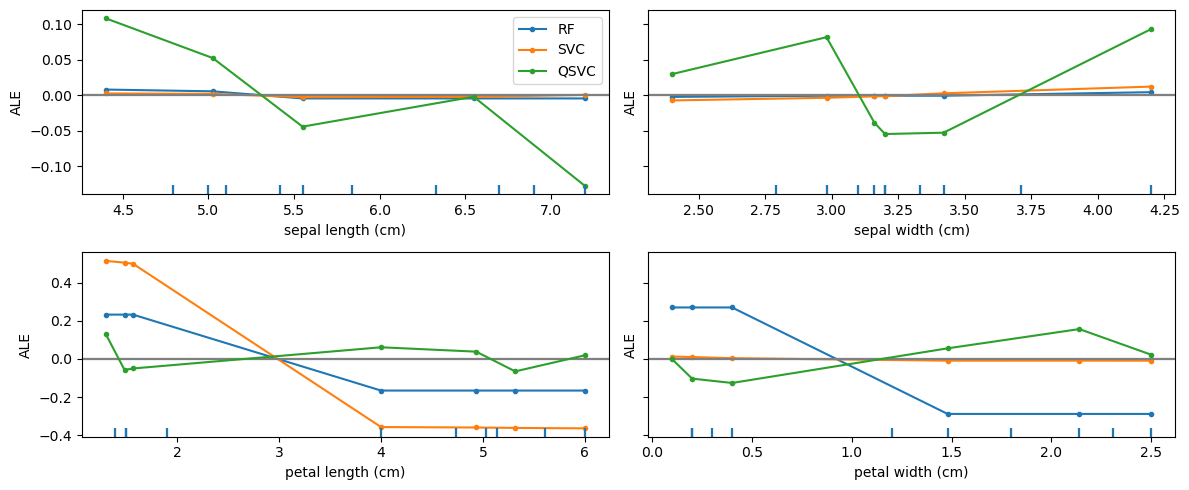

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5), sharey='row');
plot_ale(exp_rf, features=[0,1,2,3], targets=['setosa'], ax=ax, line_kw={'label': 'RF'});
plot_ale(exp_svc, features=[0,1,2,3], targets=['setosa'], ax=ax, line_kw={'label': 'SVC'});
plot_ale(exp_qsvc, features=[0,1,2,3], targets=['setosa'], ax=ax, line_kw={'label': 'QSVC'});

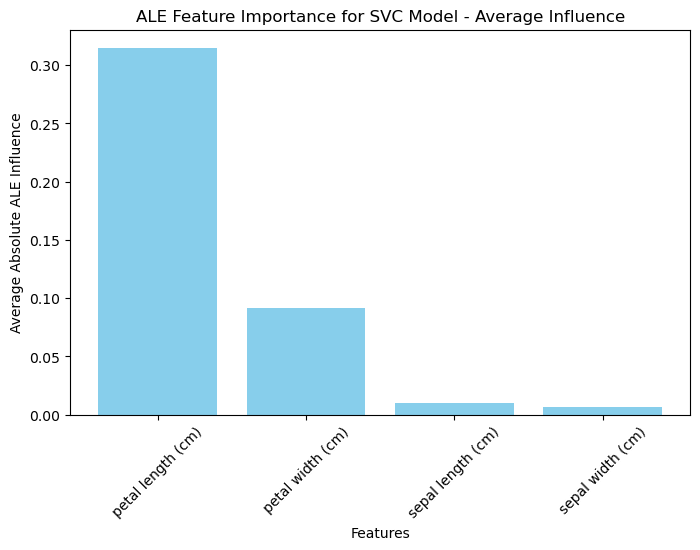

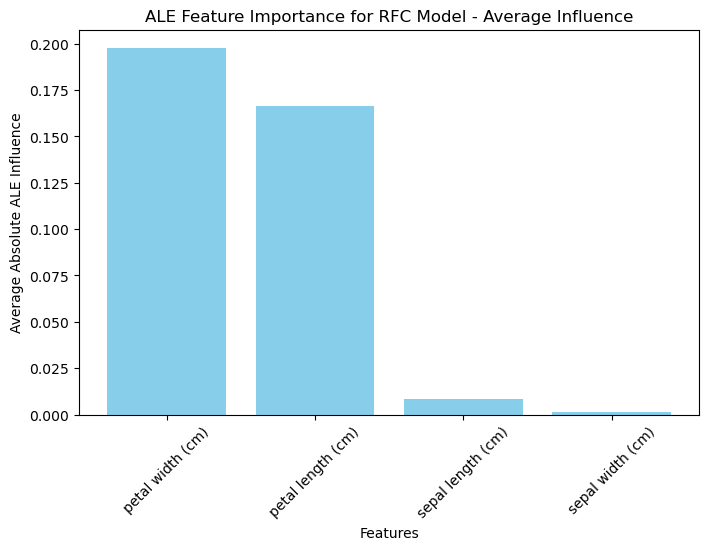

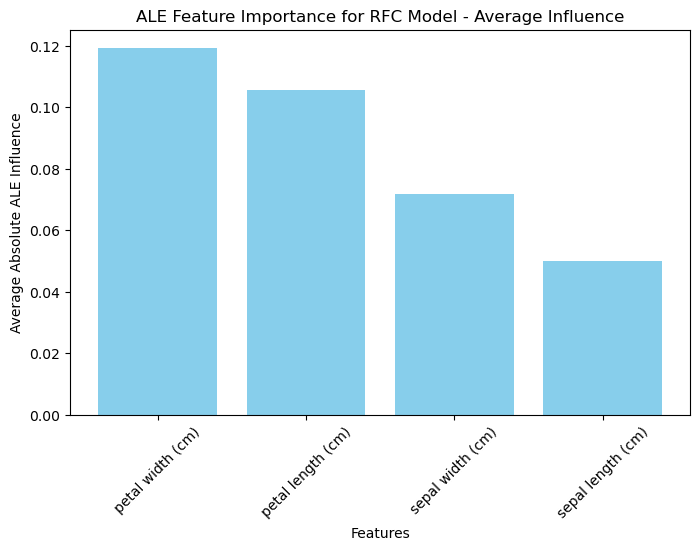

In [63]:
def ale_feature_importance(ale_exp, feature_names):
    ale_importance = {feature: np.mean(np.abs(ale_values)) for feature, ale_values in zip(feature_names, ale_exp.ale_values)}
    return ale_importance


ale_importance_svc = ale_feature_importance(exp_svc, feature_names)
ale_importance_rf = ale_feature_importance(exp_rf, feature_names)
ale_importance_qsvc = ale_feature_importance(exp_qsvc, feature_names)

# average absolute influence
def plot_ale_importance(ale_importance, title):
    features_sorted = sorted(ale_importance, key=ale_importance.get, reverse=True)
    importance_sorted = [ale_importance[feature] for feature in features_sorted]

 
    plt.figure(figsize=(8, 5))
    plt.bar(features_sorted, importance_sorted, color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Average Absolute ALE Influence')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


plot_ale_importance(ale_importance_svc, 'ALE Feature Importance for SVC Model - Average Influence')
plt.savefig('Visuals/iris_svc_ale_bar.png')
plt.close()

plot_ale_importance(ale_importance_rf, 'ALE Feature Importance for RFC Model - Average Influence')
plt.savefig('Visuals/iris_rf_ale_bar.png')
plt.close()

plot_ale_importance(ale_importance_qsvc, 'ALE Feature Importance for RFC Model - Average Influence')
plt.savefig('Visuals/iris_rf_ale_bar.png')
plt.close()

# SHAP

In [ ]:
import shap

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

train_X, test_X, train_y, test_y = train_test_split(
    features, labels, train_size=0.8, random_state=4701)

svc_model = SVC(probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

svc_model.fit(train_X, train_y)
rf_model.fit(train_X,train_y)

svc_explainer = shap.KernelExplainer(svc_model.predict, test_X)
rf_explainer = shap.KernelExplainer(rf_model.predict, test_X)
qsvc_explainer = shap.KernelExplainer(qsvc_model.predict, test_X)

svc_shap_values = svc_explainer(test_X)
rf_shap_values = rf_explainer(test_X)
qsvc_shap_values = qsvc_explainer(test_X)

shap.summary_plot(svc_shap_values, test_X, feature_names=feature_names, title='SHAP Values for SVC Model')
plt.savefig('Visuals/iris_svc_shap.png')
plt.close()
# Plot SHAP summary plot for RandomForestClassifier model
shap.summary_plot(rf_shap_values, test_X, feature_names=feature_names, title='SHAP Values for RandomForestClassifier Model')
plt.savefig('Visuals/iris_rf_shap.png')
plt.close()
shap.summary_plot(qsvc_shap_values, test_X, feature_names=feature_names, title='SHAP Values for SVC Model')
plt.savefig('Visuals/iris_qsvc_shap.png')
plt.close()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [65]:
svc_shap_values = svc_explainer.shap_values(test_X)

shap.force_plot(svc_explainer.expected_value, svc_shap_values[0,], test_X[0], feature_names=feature_names)

  0%|          | 0/30 [00:00<?, ?it/s]

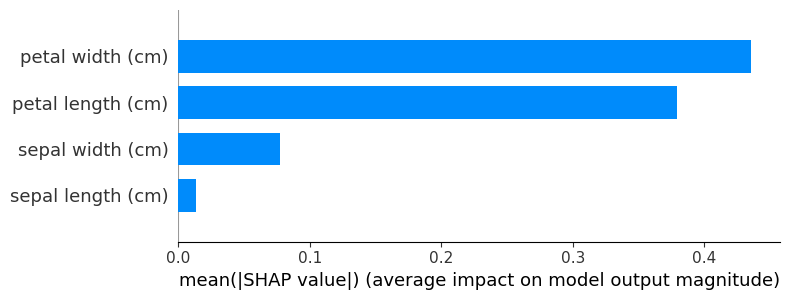

In [66]:
shap.summary_plot(svc_shap_values,feature_names = feature_names, plot_type = 'bar')

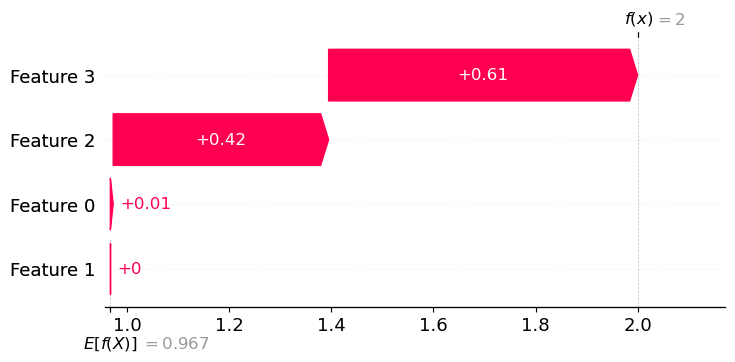

In [67]:
shap.plots._waterfall.waterfall_legacy(svc_explainer.expected_value, svc_shap_values[2])

In [68]:
rf_shap_values = rf_explainer.shap_values(test_X)

shap.force_plot(rf_explainer.expected_value, rf_shap_values[0,], test_X[0], feature_names=feature_names)

  0%|          | 0/30 [00:00<?, ?it/s]

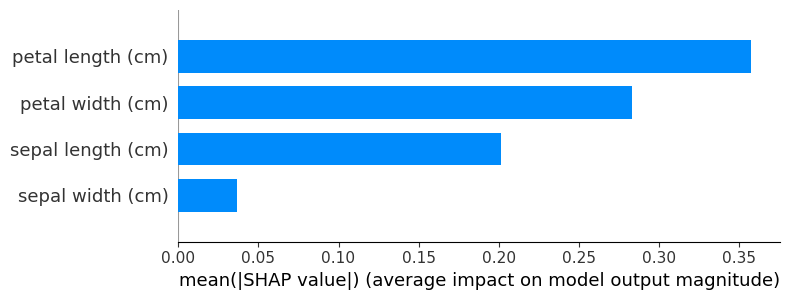

In [69]:
shap.summary_plot(rf_shap_values,feature_names = feature_names, plot_type = 'bar')

# Permutation Importance

In [ ]:
shap.plots.heatmap(rf_shap_values[0,])